In [1]:
import pandas as pd
import numpy as np
import re

results_log_path = r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\vision_log.txt'

# Load and parse log data
all_results = []
with open(results_log_path, 'r') as f:
    for line in f:
        match = re.search(r"Subject: (\w+),.*GT CPR cycles: ([\d.]+), Predicted CPR cycles: ([\d.]+)", line)
        if match:
            subject = match.group(1)
            gt_cycles = float(match.group(2))
            predicted_cycles = float(match.group(3))
            error = abs(gt_cycles - predicted_cycles)
            all_results.append([subject, gt_cycles, predicted_cycles, error])

# Create DataFrame
df = pd.DataFrame(all_results, columns=['Subject', 'GT CPR cycles', 'Predicted CPR cycles', 'Error'])

# Calculate averages per subject
summary_df = df.groupby('Subject').agg({
    'GT CPR cycles': 'mean',
    'Predicted CPR cycles': 'mean',
    'Error': 'mean'
}).reset_index()

# Rename columns for clarity
summary_df.columns = ['Subject', 'Average GT CPR cycles', 'Average Predicted CPR cycles', 'Average Error']

# Save to CSV
summary_df.to_csv(r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\subject_summary.csv', index=False)

print('Analysis complete. Results saved to subject_summary.csv.')


Analysis complete. Results saved to subject_summary.csv.


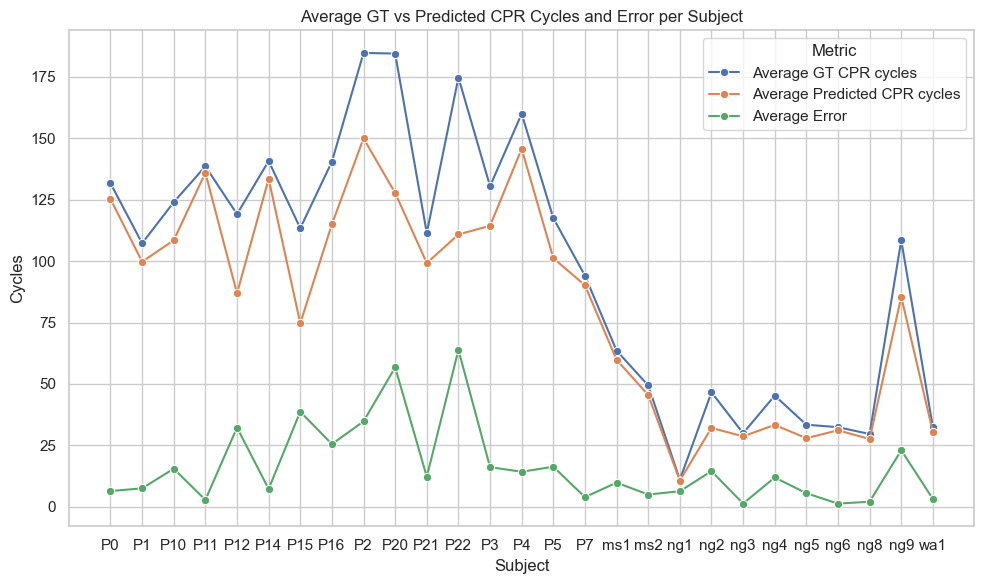

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the summary data
summary_df = pd.read_csv(r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\subject_summary.csv')

# Set up the plot style
sns.set(style="whitegrid")

# Melt the DataFrame to use in Seaborn
melted_df = summary_df.melt(id_vars='Subject', 
                            value_vars=['Average GT CPR cycles', 'Average Predicted CPR cycles', 'Average Error'],
                            var_name='Metric', value_name='Cycles')

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_df, x='Subject', y='Cycles', hue='Metric', marker="o")

# Add plot labels and title
plt.title('Average GT vs Predicted CPR Cycles and Error per Subject')
plt.xlabel('Subject')
plt.ylabel('Cycles')

# Display the plot
plt.tight_layout()
plt.show()


# Window wise detection

In [8]:
import pandas as pd
import numpy as np
import re

results_log_path = r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\window_vision_log.txt'

# Load and parse log data
all_results = []
with open(results_log_path, 'r') as f:
    for line in f:
        match = re.search(r"File: (\w+)_keypoints\.json, Window (\d+), Predicted CPR cycles: ([\d.]+), GT CPR cycles: ([\d.]+)", line)
        if match:
            subject = match.group(1).split('_')[0]
            window = int(match.group(2))
            predicted_cycles = float(match.group(3))
            gt_cycles = float(match.group(4))
            error = abs(gt_cycles - predicted_cycles)
            
            # Calculate CPR cycles per minute for GT, Predicted, and Error
            gt_cycles_per_min = (gt_cycles / 5) * 60
            predicted_cycles_per_min = (predicted_cycles / 5) * 60
            error_per_min = (error / 5) * 60
            
            all_results.append([subject, window, gt_cycles, predicted_cycles, error, gt_cycles_per_min, predicted_cycles_per_min, error_per_min])

# Create DataFrame
df = pd.DataFrame(all_results, columns=[
    'Subject', 'Window', 'GT CPR cycles', 'Predicted CPR cycles', 'Error', 
    'GT CPR cycles per min', 'Predicted CPR cycles per min', 'Error per min'
])

# Calculate averages per subject
summary_df = df.groupby('Subject').agg({
    'GT CPR cycles': 'mean',
    'Predicted CPR cycles': 'mean',
    'Error': 'mean',
    'GT CPR cycles per min': 'mean',
    'Predicted CPR cycles per min': 'mean',
    'Error per min': 'mean'
}).reset_index()

# Rename columns for clarity
summary_df.columns = [
    'Subject', 'Average GT CPR cycles', 'Average Predicted CPR cycles', 
    'Average Error', 'Average GT CPR cycles per min', 'Average Predicted CPR cycles per min', 
    'Average Error per min'
]

# Save to CSV
summary_df.to_csv(r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\window_subject_summary.csv', index=False)

print('Window-wise summary complete. Results saved to window_subject_summary.csv.')


Window-wise summary complete. Results saved to window_subject_summary.csv.


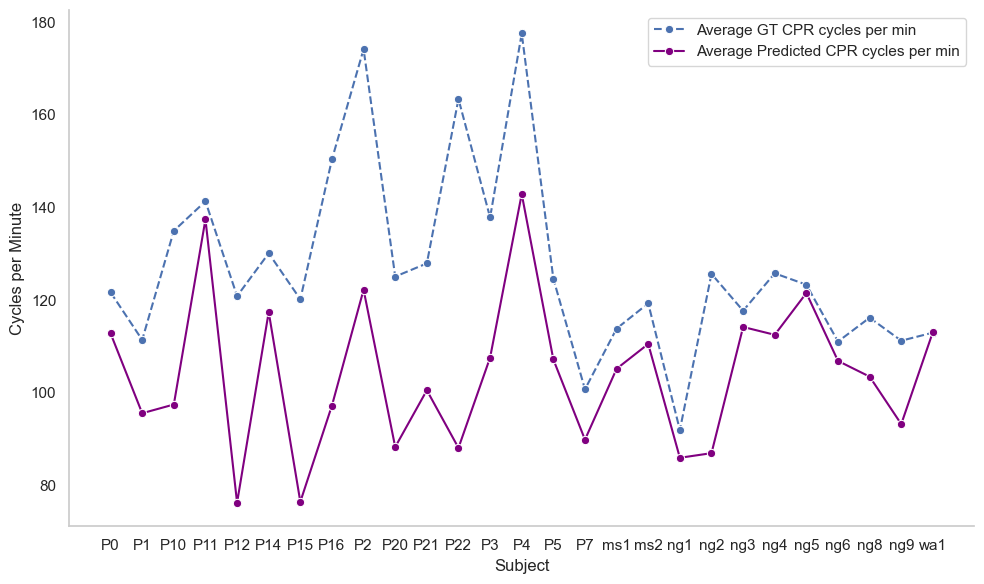

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the summary data
summary_df = pd.read_csv(r'E:\EgoExoEMS\Benchmarks\CPR_quality\vision\window_subject_summary.csv')

# Set up the plot style
sns.set(style="whitegrid")

# Melt the DataFrame to use in Seaborn
melted_df = summary_df.melt(id_vars='Subject', 
                            value_vars=['Average GT CPR cycles per min', 'Average Predicted CPR cycles per min'],
                            var_name='Metric', value_name='Cycles')

# Create the line plot with customized style
plt.figure(figsize=(10, 6))

# Plot GT rate with dashed line
sns.lineplot(
    data=melted_df[melted_df['Metric'] == 'Average GT CPR cycles per min'], 
    x='Subject', y='Cycles', label='Average GT CPR cycles per min', 
    linestyle='--',  marker="o"
)

# Plot Predicted rate with solid purple line
sns.lineplot(
    data=melted_df[melted_df['Metric'] == 'Average Predicted CPR cycles per min'], 
    x='Subject', y='Cycles', label='Average Predicted CPR cycles per min', 
    linestyle='-', color='purple', marker="o"
)

# Add plot labels and title
# plt.title('Average GT vs Predicted CPR Cycles per Minute per Subject')
plt.xlabel('Subject')
plt.ylabel('Cycles per Minute')

sns.despine()

# Disable grid
plt.grid(False)

# Display the plot
plt.tight_layout()
plt.show()
